In [22]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import netCDF4
import xarray as xr
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

from scipy import stats

C:\Users\pkoll\AppData\Local\Temp\ipykernel_17680\1459816379.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### ALL FUNCTIONS

In [4]:
def orbits_finder(df):
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [5]:
def orbits_finder_more_returns(df):
    # BASED ON SWP, FIND LWP
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    starts = []
    ends = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        starts.append(start_time)
        end_time = start_time + time_diff
        ends.append(end_time)
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return starts, ends

In [6]:
def orbits_finder_lw(starts,ends, df):
    data = df.N2.mean(dim = 'row')
    data_np = data.to_numpy()

    all_orbits = []
    for i in range(0,len(starts)):
        df_orbit = df.sel(time=slice(starts[i], ends[i]))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [7]:
def single_orb(orbit_arr,n):
    orb = orbit_arr[n].mean(dim = 'row')
    t = orb.time
    
    if 'I_1356' in orb.variables.keys():
        val = orb.I_1356
    elif 'N2' in orb.variables.keys():
        val = orb.N2
        
    return(t, val)

In [8]:
def data_opening_w_stripe(stripe, d):
    dsf_raw = xr.open_dataset(d,engine = 'netcdf4')  

    # FOR FUV A SWP
    if 'ICON_L1_FUVA_SWP_Center_Times' in dsf_raw.variables.keys():
        dsf = dsf_raw[['ICON_L1_FUVA_SWP_Center_Times','ICON_L1_FUVA_SWP_PROF_'+str(stripe)]]
        # Convert times to something Python and xarray can understand, and reindex the dataset by time 
        t = pd.to_datetime(dsf.ICON_L1_FUVA_SWP_Center_Times.values)
        dsf['time'] = (['Epoch'], t)
        dsf = dsf.swap_dims({'Epoch':'time'})
        dsf = dsf.rename({'Rows':'row'})
        # Rename and drop useless variables
        dsf['I_1356'] = dsf['ICON_L1_FUVA_SWP_PROF_'+str(stripe)]
        dsf = dsf.drop(['ICON_L1_FUVA_SWP_PROF_'+str(stripe),'ICON_L1_FUVA_SWP_Center_Times','Epoch'])
    
    # FOR FUV B LWP
    elif 'ICON_L1_FUVB_LWP_Center_Times' in dsf_raw.variables.keys():
        dsf = dsf_raw[['ICON_L1_FUVB_LWP_Center_Times','ICON_L1_FUVB_LWP_PROF_'+str(stripe)]]
        # Convert times to something Python and xarray can understand, and reindex the dataset by time 
        t = pd.to_datetime(dsf.ICON_L1_FUVB_LWP_Center_Times.values)
        dsf['time'] = (['Epoch'], t)
        dsf = dsf.swap_dims({'Epoch':'time'})
        dsf = dsf.rename({'Rows':'row'})
        #  Rename and drop useless variables
        dsf['N2'] = dsf['ICON_L1_FUVB_LWP_PROF_'+str(stripe)]
        dsf = dsf.drop(['ICON_L1_FUVB_LWP_PROF_'+str(stripe),'ICON_L1_FUVB_LWP_Center_Times','Epoch'])    
      
    return dsf

In [9]:
def stripes_lineplot(n,day):
    plt.figure()
    plt.title("Comparing Stripes of FUV Data for Orbit "+str(n)+ " on " + day +" 2020")

    plt.plot(single_orb(swp_p0_all,n)[0],single_orb(swp_p0_all,n)[1],marker = '.', label = 'PO SWP')
    plt.plot(single_orb(swp_p3_all,n)[0],single_orb(swp_p3_all,n)[1],marker = '.', label = 'P3 SWP')
    plt.plot(single_orb(swp_p6_all,n)[0],single_orb(swp_p6_all,n)[1],marker = '.', label = 'P6 SWP')
    plt.plot(single_orb(swp_m3_all,n)[0],single_orb(swp_m3_all,n)[1],marker = '.', label = 'M3 SWP')
    plt.plot(single_orb(swp_m6_all,n)[0],single_orb(swp_m6_all,n)[1],marker = '.', label = 'M6 SWP')
    plt.plot(single_orb(swp_m9_all,n)[0],single_orb(swp_m9_all,n)[1],marker = '.', label = 'M9 SWP')

    plt.plot(single_orb(lwp_p0_all,n)[0],single_orb(lwp_p0_all,n)[1],marker = '.', label = 'PO LWP')
    plt.plot(single_orb(lwp_p3_all,n)[0],single_orb(lwp_p3_all,n)[1],marker = '.', label = 'P3 LWP')
    plt.plot(single_orb(lwp_p6_all,n)[0],single_orb(lwp_p6_all,n)[1],marker = '.', label = 'P6 LWP')
    plt.plot(single_orb(lwp_m3_all,n)[0],single_orb(lwp_m3_all,n)[1],marker = '.', label = 'M3 LWP')
    plt.plot(single_orb(lwp_m6_all,n)[0],single_orb(lwp_m6_all,n)[1],marker = '.', label = 'M6 LWP')
    plt.plot(single_orb(lwp_m9_all,n)[0],single_orb(lwp_m9_all,n)[1],marker = '.', label = 'M9 LWP')

    plt.legend()
    plt.show()


In [10]:
def fuv_plots_smoothed(orbit_data,day,orbit_num):
    
    if 'I_1356' in orbit_data.variables.keys():
        # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
        orbit_data['I_1356_filt'] = orbit_data['I_1356'] - orbit_data['I_1356'].rolling(time=17, center=True).mean() 
        
        # FUV Plot
        plt.figure(figsize=(10,3))
        #vm = abs(orbit_data.I_1356_filt).quantile(0.95) 
        vm = 60
        plt.pcolormesh(pd.to_datetime(orbit_data.time.values), orbit_data.row, orbit_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
        plt.ylabel('Row')
        plt.colorbar(label='R')
        plt.title(f'FUV SWP 1356 brightness on {day} (Orbit {orbit_num})')

        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()
        
    elif 'N2' in orbit_data.variables.keys():
        # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
        orbit_data['N2_filt'] = orbit_data['N2'] - orbit_data['N2'].rolling(time=17, center=True).mean()
        orbit_data['N2_filt'] = orbit_data['N2_filt'].rolling(time=3, center=True).mean()
        # FUV Plot
        plt.figure(figsize=(10,3))
        #vm = abs(orbit_data.N2_filt).quantile(0.95) 
        vm = 15
        plt.pcolormesh(pd.to_datetime(orbit_data.time.values), orbit_data.row, orbit_data.N2_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
        plt.ylabel('Row')
        plt.colorbar(label='R')
        plt.title(f'FUV LWP N2 on {day} (Orbit {orbit_num})')
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()
        

### DATA

In [11]:
L1f_swp_01 = 'ICON_L1_FUV_SWP_2020-01-01_v05r000.NC'
L1f_lwp_01 = 'ICON_L1_FUV_LWP_2020-01-01_v05r000.NC'

In [12]:
# ALL STRIPES FOR SWP
swp_m9 = data_opening_w_stripe('M9',L1f_swp_01)
swp_m6 = data_opening_w_stripe('M6',L1f_swp_01)
swp_m3 = data_opening_w_stripe('M3',L1f_swp_01)
swp_p0 = data_opening_w_stripe('P0',L1f_swp_01)
swp_p3 = data_opening_w_stripe('P3',L1f_swp_01)
swp_p6 = data_opening_w_stripe('P6',L1f_swp_01)

# ALL STRIPES FOR LWP
lwp_m9 = data_opening_w_stripe('M9',L1f_lwp_01)
lwp_m6 = data_opening_w_stripe('M6',L1f_lwp_01)
lwp_m3 = data_opening_w_stripe('M3',L1f_lwp_01)
lwp_p0 = data_opening_w_stripe('P0',L1f_lwp_01)
lwp_p3 = data_opening_w_stripe('P3',L1f_lwp_01)
lwp_p6 = data_opening_w_stripe('P6',L1f_lwp_01)


In [13]:
# ALL 
swp_p0_all = orbits_finder(swp_p0)
swp_p3_all = orbits_finder(swp_p3)
swp_p6_all = orbits_finder(swp_p6)
swp_m3_all = orbits_finder(swp_m3)
swp_m6_all = orbits_finder(swp_m6)
swp_m9_all = orbits_finder(swp_m9)

lwp_p0_all = orbits_finder_lw(orbits_finder_more_returns(swp_p0)[0],orbits_finder_more_returns(swp_p0)[1],lwp_p0)
lwp_p3_all = orbits_finder_lw(orbits_finder_more_returns(swp_p3)[0],orbits_finder_more_returns(swp_p3)[1],lwp_p3)
lwp_p6_all = orbits_finder_lw(orbits_finder_more_returns(swp_p6)[0],orbits_finder_more_returns(swp_p6)[1],lwp_p6)
lwp_m3_all = orbits_finder_lw(orbits_finder_more_returns(swp_m3)[0],orbits_finder_more_returns(swp_m3)[1],lwp_m3)
lwp_m6_all = orbits_finder_lw(orbits_finder_more_returns(swp_m6)[0],orbits_finder_more_returns(swp_m6)[1],lwp_m6)
lwp_m9_all = orbits_finder_lw(orbits_finder_more_returns(swp_m9)[0],orbits_finder_more_returns(swp_m9)[1],lwp_m9)


<IPython.core.display.Javascript object>


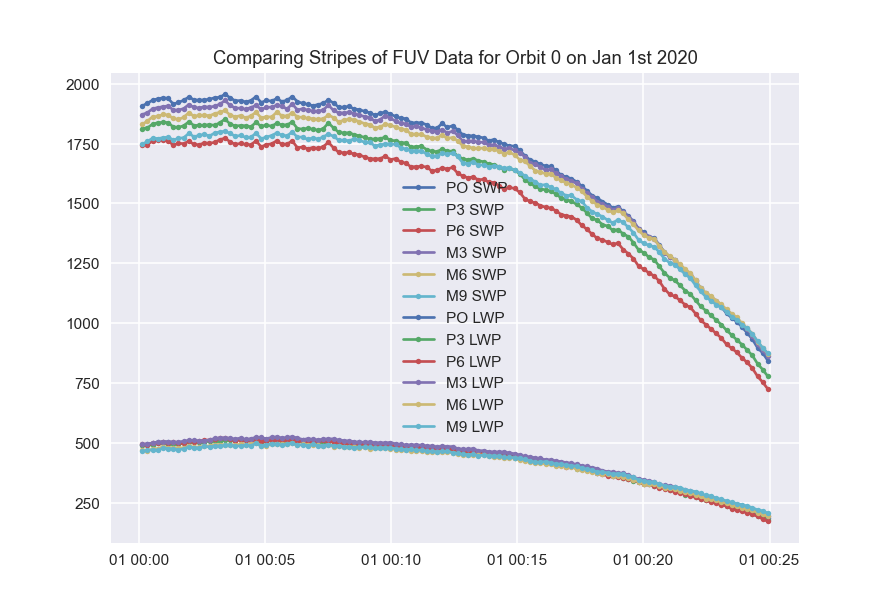

In [11]:
stripes_lineplot(0, 'Jan 1st')

<IPython.core.display.Javascript object>


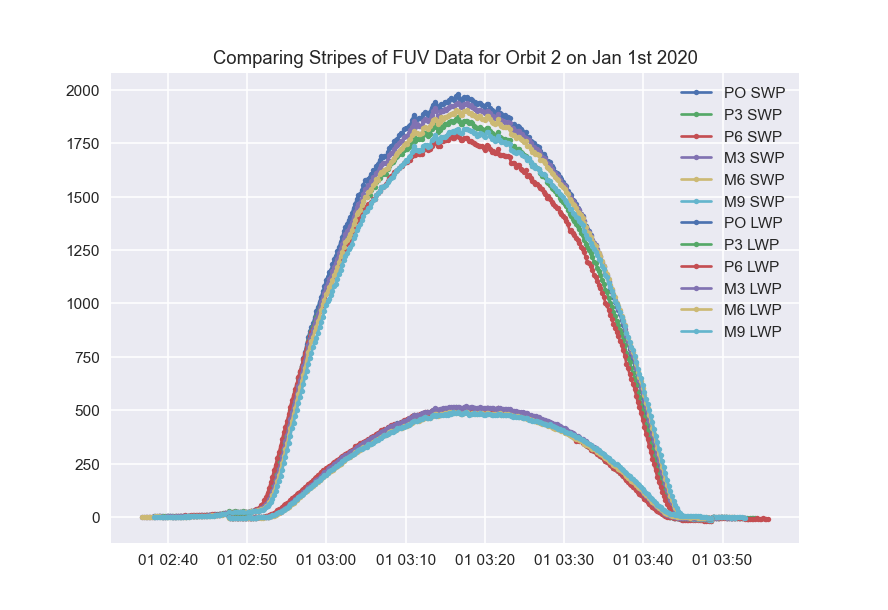

In [12]:
stripes_lineplot(2,'Jan 1st')

<IPython.core.display.Javascript object>


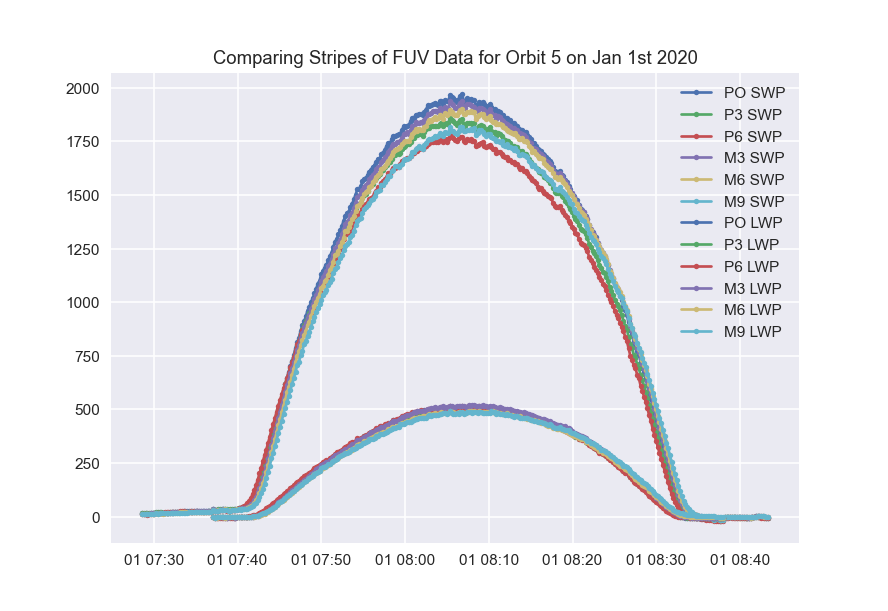

In [13]:
stripes_lineplot(5,'Jan 1st')

<IPython.core.display.Javascript object>


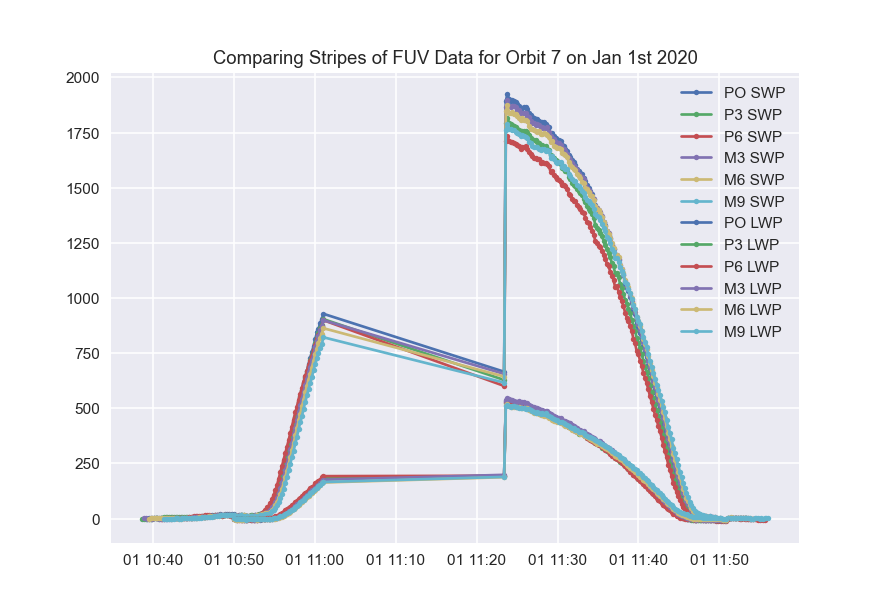

In [15]:
stripes_lineplot(7, "Jan 1st")

### FUVs

In [50]:
def limb_fuv_line_plots_focused(swp_data,lwp_data,day,orbit_num):
    
    if 'I_1356' in swp_data.variables.keys():
        # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
        swp_data['I_1356_filt'] = swp_data['I_1356'] - swp_data['I_1356'].rolling(time=17, center=True).mean() 
        swp_data['I_1356_filt'] = swp_data['I_1356_filt'].rolling(time=3, center=True).mean()

        
        #SLICE OUT END FEATURES
        s = len(swp_data["I_1356_filt"])
        lim_val = int(s/6)
        s_lim = int(1.5 * lim_val)

        time_start = swp_data['time'].isel(time=s_lim).values
        time_end =  swp_data['time'].isel(time=lim_val * 5).values
        swp_data = swp_data.sel(time=slice(time_start, time_end))
        
        #SLICE ROWS
        swp_sel_rows = swp_data.isel(row=slice(170, 201))
        
        swp_row_means = swp_sel_rows.mean(dim = 'row')
        swp_line_data = swp_row_means.dropna(dim = 'time')
        swp_t = swp_line_data.time

    # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    lwp_data['N2_filt'] = lwp_data['N2'] - lwp_data['N2'].rolling(time=17, center=True).mean()
    lwp_data['N2_filt'] = lwp_data['N2_filt'].rolling(time=3, center=True).mean()
    lwp_data = lwp_data.sel(time=slice(time_start, time_end))

    #SLICE ROWS
    lwp_sel_rows = lwp_data.isel(row=slice(170, 201))    
    lwp_row_means = lwp_sel_rows.mean(dim = 'row')
    lwp_line_data = lwp_row_means.dropna(dim = 'time')
    lwp_t = lwp_line_data.time

        
    # INITIALIZE PLOT FOR FUVs
    (fig, (ax1, ax2)) = plt.subplots(nrows=2, ncols=1, figsize = (10,15))

    # FUV 1- SWP
    vm_1 = 60 
    pcm_1 = ax1.pcolormesh(pd.to_datetime(swp_data.time.values), swp_data.row, swp_data.I_1356_filt.T, cmap='plasma', vmin=-vm_1, vmax=vm_1)
    ax1.set_ylabel('Row')
    ax1.axhline (170)
    ax1.axhline(200)
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title(f'FUV SWP 1356 brightness on {day} (Orbit {orbit_num})')  
    
    # FUV 2- LWP
    vm_2 = 15 # Choose max of colorbar (i.e., contrast)
    pcm_2 = ax2.pcolormesh(pd.to_datetime(lwp_data.time.values), lwp_data.row, lwp_data.N2_filt.T, cmap='plasma', vmin=-vm_2, vmax=vm_2)
    ax2.set_ylabel('row')
    ax2.axhline (170)
    ax2.axhline(200)
    #ax2.colorbar(label='R')
    fig.colorbar(pcm_2, ax = ax2, label='R')
    ax2.set_title(f'FUV LWP N2 on {day} (Orbit {orbit_num})')      
   
     # Line Plot
#     ax3.set_title(f'FUV brightness on {day} (Orbit {orbit_num})')
#     ax3.plot(swp_t,swp_line_data['I_1356_filt'],'b',label = 'SWP 1356 Emission')
#     ax3.plot(lwp_t,lwp_line_data['N2_filt'],'r',label = 'LWP N2 Emission')
#     ax3.legend()
    
    plt.tight_layout()


In [70]:
from scipy import stats

In [52]:
def limb_fuv_line_plots_corr(swp_data,lwp_data,day,orbit_num):
    
    if 'I_1356' in swp_data.variables.keys():
        # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
        swp_data['I_1356_filt'] = swp_data['I_1356'] - swp_data['I_1356'].rolling(time=17, center=True).mean() 
        swp_data['I_1356_filt'] = swp_data['I_1356_filt'].rolling(time=3, center=True).mean()

        
        #SLICE OUT END FEATURES
        s = len(swp_data["I_1356_filt"])
        lim_val = int(s/6)
        s_lim = int(1.5 * lim_val)

        time_start = swp_data['time'].isel(time=s_lim).values
        time_end =  swp_data['time'].isel(time=lim_val * 5).values
        swp_data = swp_data.sel(time=slice(time_start, time_end))
        
        #SLICE ROWS
        swp_sel_rows = swp_data.isel(row=slice(170, 201)) 
        swp_row_means = swp_sel_rows.mean(dim = 'row')
        swp_line_data = swp_row_means.dropna(dim = 'time')
        swp_t = swp_line_data.time

    # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    lwp_data['N2_filt'] = lwp_data['N2'] - lwp_data['N2'].rolling(time=17, center=True).mean()
    lwp_data['N2_filt'] = lwp_data['N2_filt'].rolling(time=3, center=True).mean()
    lwp_data = lwp_data.sel(time=slice(time_start, time_end))

    #SLICE ROWS
    lwp_sel_rows = lwp_data.isel(row=slice(170, 201))    
    lwp_row_means = lwp_sel_rows.mean(dim = 'row')
    lwp_line_data = lwp_row_means.dropna(dim = 'time')
    lwp_t = lwp_line_data.time
    
    
    #Pearson Corr
    corr = stats.pearsonr(swp_line_data['I_1356_filt'][:-1], lwp_line_data['N2_filt'])
    print(corr)
    # Had to take 1 point off the end (checked w the plots, this is chill doesn't make a difference I think)
        
    # INITIALIZE PLOTS
    (fig, (ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize = (10,15))

    # FUV 1- SWP
    vm_1 = 60 
    pcm_1 = ax1.pcolormesh(pd.to_datetime(swp_sel_rows.time.values), swp_sel_rows.row, swp_sel_rows.I_1356_filt.T, cmap='plasma', vmin=-vm_1, vmax=vm_1)
    ax1.set_ylabel('Row')
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title(f'FUV SWP 1356 brightness on {day} (Orbit {orbit_num})')  

    # FUV 2- LWP
    vm_2 = 15 # Choose max of colorbar (i.e., contrast)
    pcm_2 = ax2.pcolormesh(pd.to_datetime(lwp_sel_rows.time.values), lwp_sel_rows.row, lwp_sel_rows.N2_filt.T, cmap='plasma', vmin=-vm_2, vmax=vm_2)
    ax2.set_ylabel('row')
    fig.colorbar(pcm_2, ax = ax2, label='R')
    ax2.set_title(f'FUV LWP N2 on {day} (Orbit {orbit_num})')     
    
    rounded_corr = float(f"{corr.statistic:.{4}g}")
    rounded_pval = float(f"{corr.pvalue:.{4}g}")


    # Line Plot
    ax3.set_title(f'FUV brightness on {day} (Orbit {orbit_num})\n Correlation =' + str(rounded_corr)+' ,P Value =' + str(rounded_pval))
    ax3.plot(swp_t,swp_line_data['I_1356_filt'],'b',label = 'SWP 1356 Emission')
    ax3.plot(lwp_t,lwp_line_data['N2_filt'],'r',label = 'LWP N2 Emission')
    ax3.legend()

    plt.tight_layout()



In [53]:
def limb_plots(day,n):
    swp = orbits_finder(swp_p0)[n]
    lwp = orbits_finder_lw(orbits_finder_more_returns(swp_p0)[0],orbits_finder_more_returns(swp_p0)[1],lwp_p0)[n]
    limb_fuv_line_plots_focused(swp,lwp,str(day), str(n))
    limb_fuv_line_plots_corr(swp,lwp,str(day), str(n))

  

#### Orbit 3 (Triplett Paper Orbit)

<IPython.core.display.Javascript object>


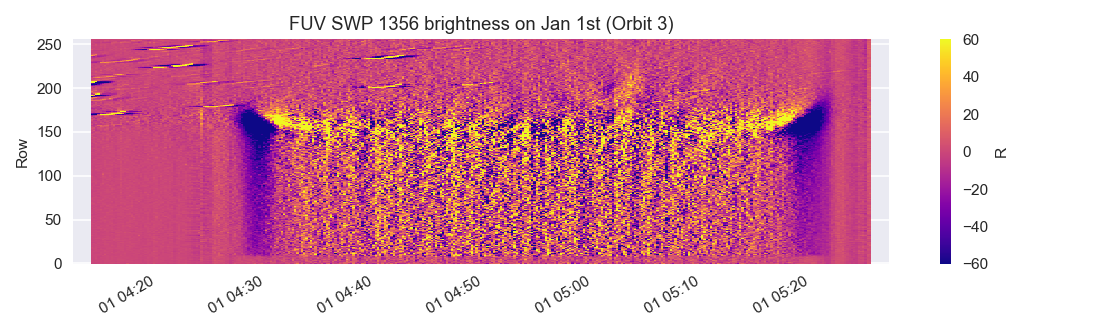

<IPython.core.display.Javascript object>


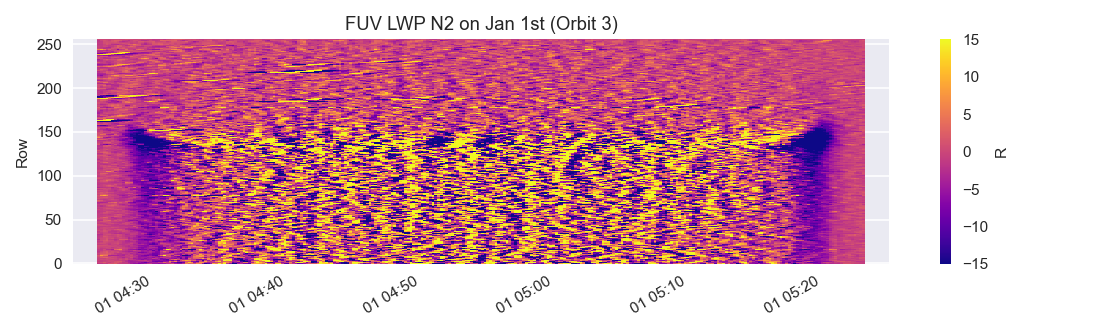

In [15]:
fuvs("Jan 1st",3)

<IPython.core.display.Javascript object>


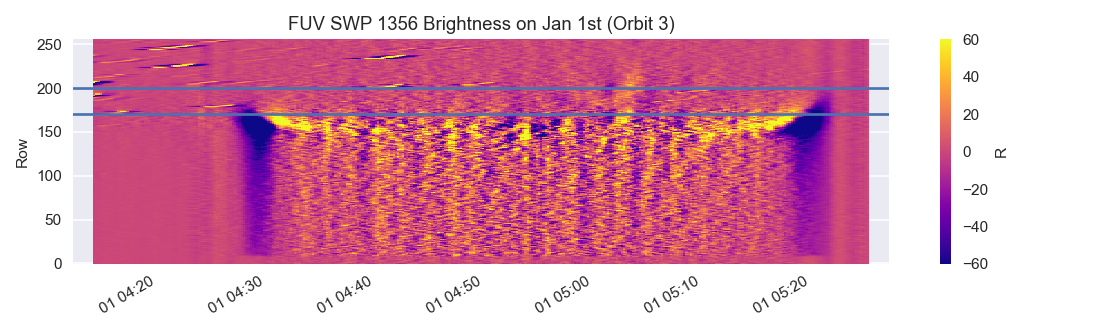

<IPython.core.display.Javascript object>


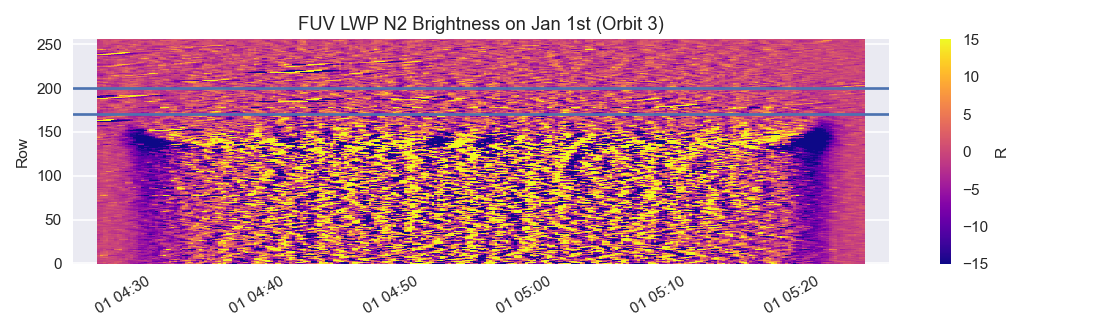

In [48]:
# Want to focus specifically on the limb where the diagonal structures are...
swp = orbits_finder(swp_p0)[3]
lwp = orbits_finder_lw(orbits_finder_more_returns(swp_p0)[0],orbits_finder_more_returns(swp_p0)[1],lwp_p0)[3]


# SWP
# Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
swp['I_1356_filt'] = swp['I_1356'] - swp['I_1356'].rolling(time=17, center=True).mean() 
swp['I_1356_filt'] = swp['I_1356_filt'].rolling(time=3, center=True).mean()

plt.figure(figsize=(10,3))
#vm = abs(orbit_data.I_1356_filt).quantile(0.95) 
vm = 60
plt.pcolormesh(pd.to_datetime(swp.time.values), swp.row, swp.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
plt.axhline (170)
plt.axhline(200)
plt.ylabel('Row')
plt.colorbar(label='R')
plt.title(f'FUV SWP 1356 Brightness on Jan 1st (Orbit 3)')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

#LWP
# Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
lwp['N2_filt'] = lwp['N2'] - lwp['N2'].rolling(time=17, center=True).mean()
lwp['N2_filt'] = lwp['N2_filt'].rolling(time=3, center=True).mean()

plt.figure(figsize=(10,3))
#vm = abs(orbit_data.N2_filt).quantile(0.95) 
vm = 15
plt.pcolormesh(pd.to_datetime(lwp.time.values), lwp.row, lwp.N2_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
plt.axhline (170)
plt.axhline(200)
plt.ylabel('Row')
plt.colorbar(label='R')
plt.title(f'FUV LWP N2 Brightness on Jan 1st (Orbit 3)')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()



<IPython.core.display.Javascript object>


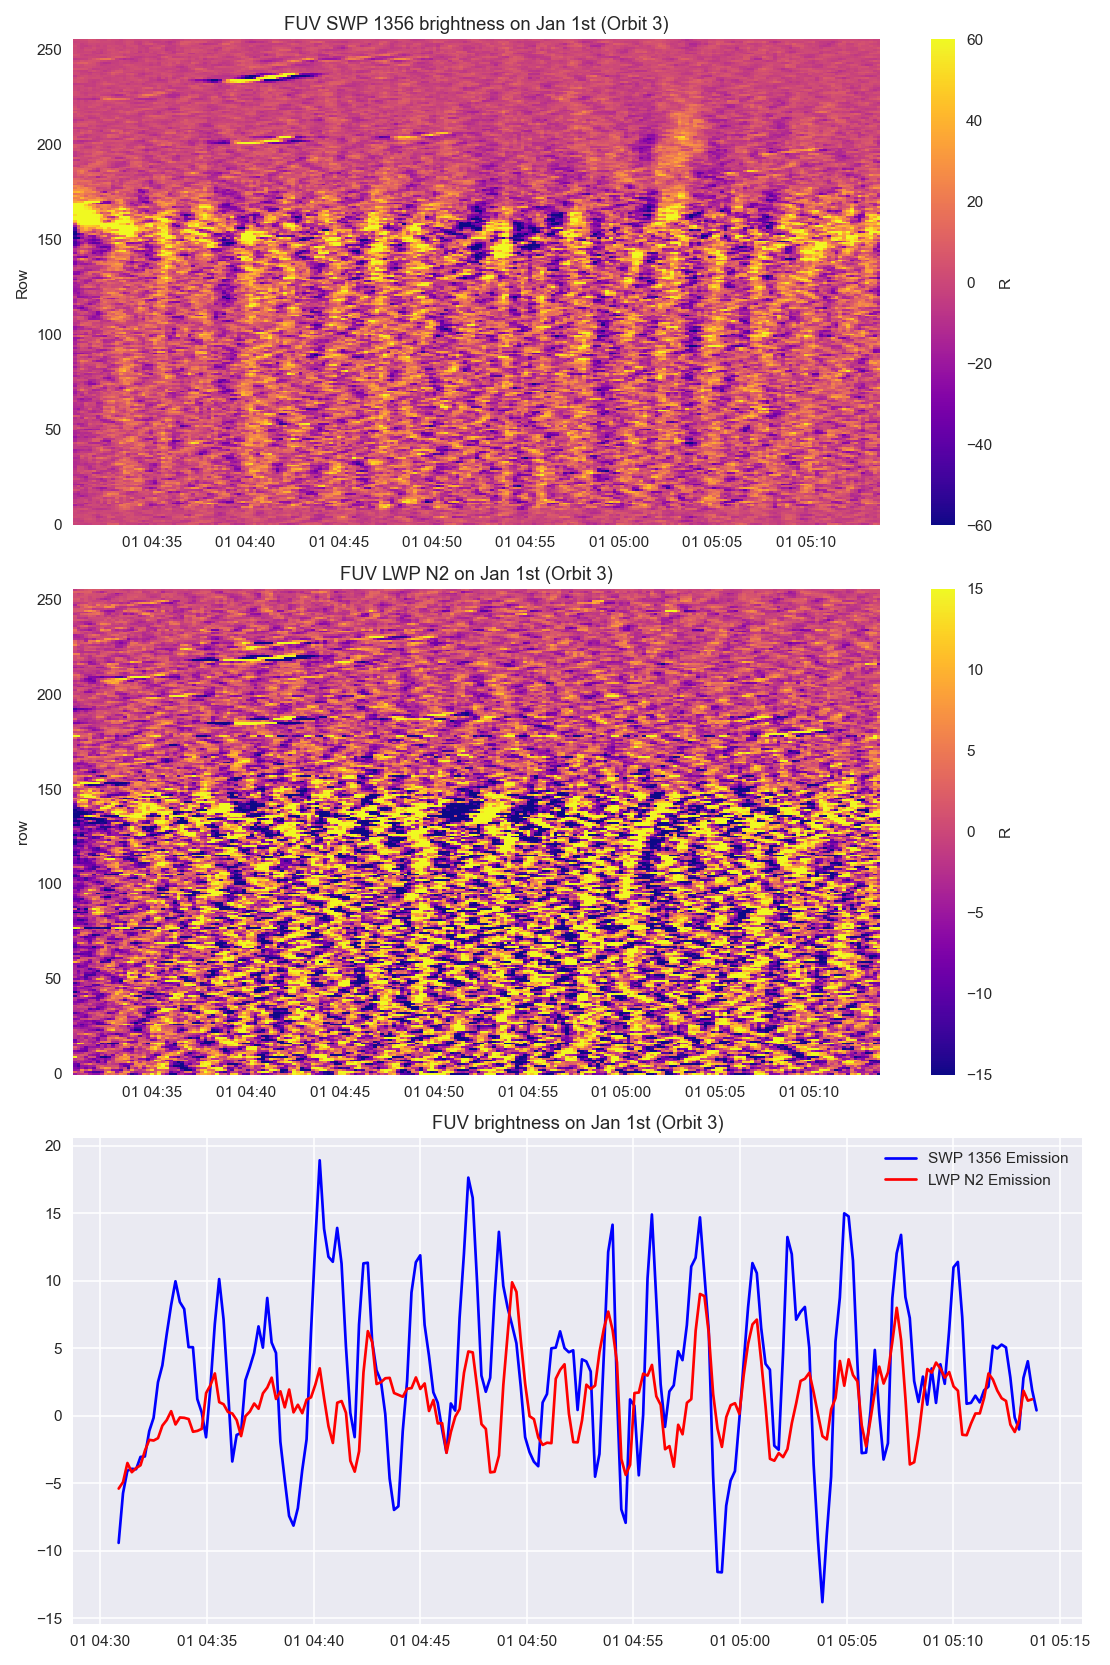

In [54]:
sel_focused_fuvs("Jan 1st",3)

<IPython.core.display.Javascript object>


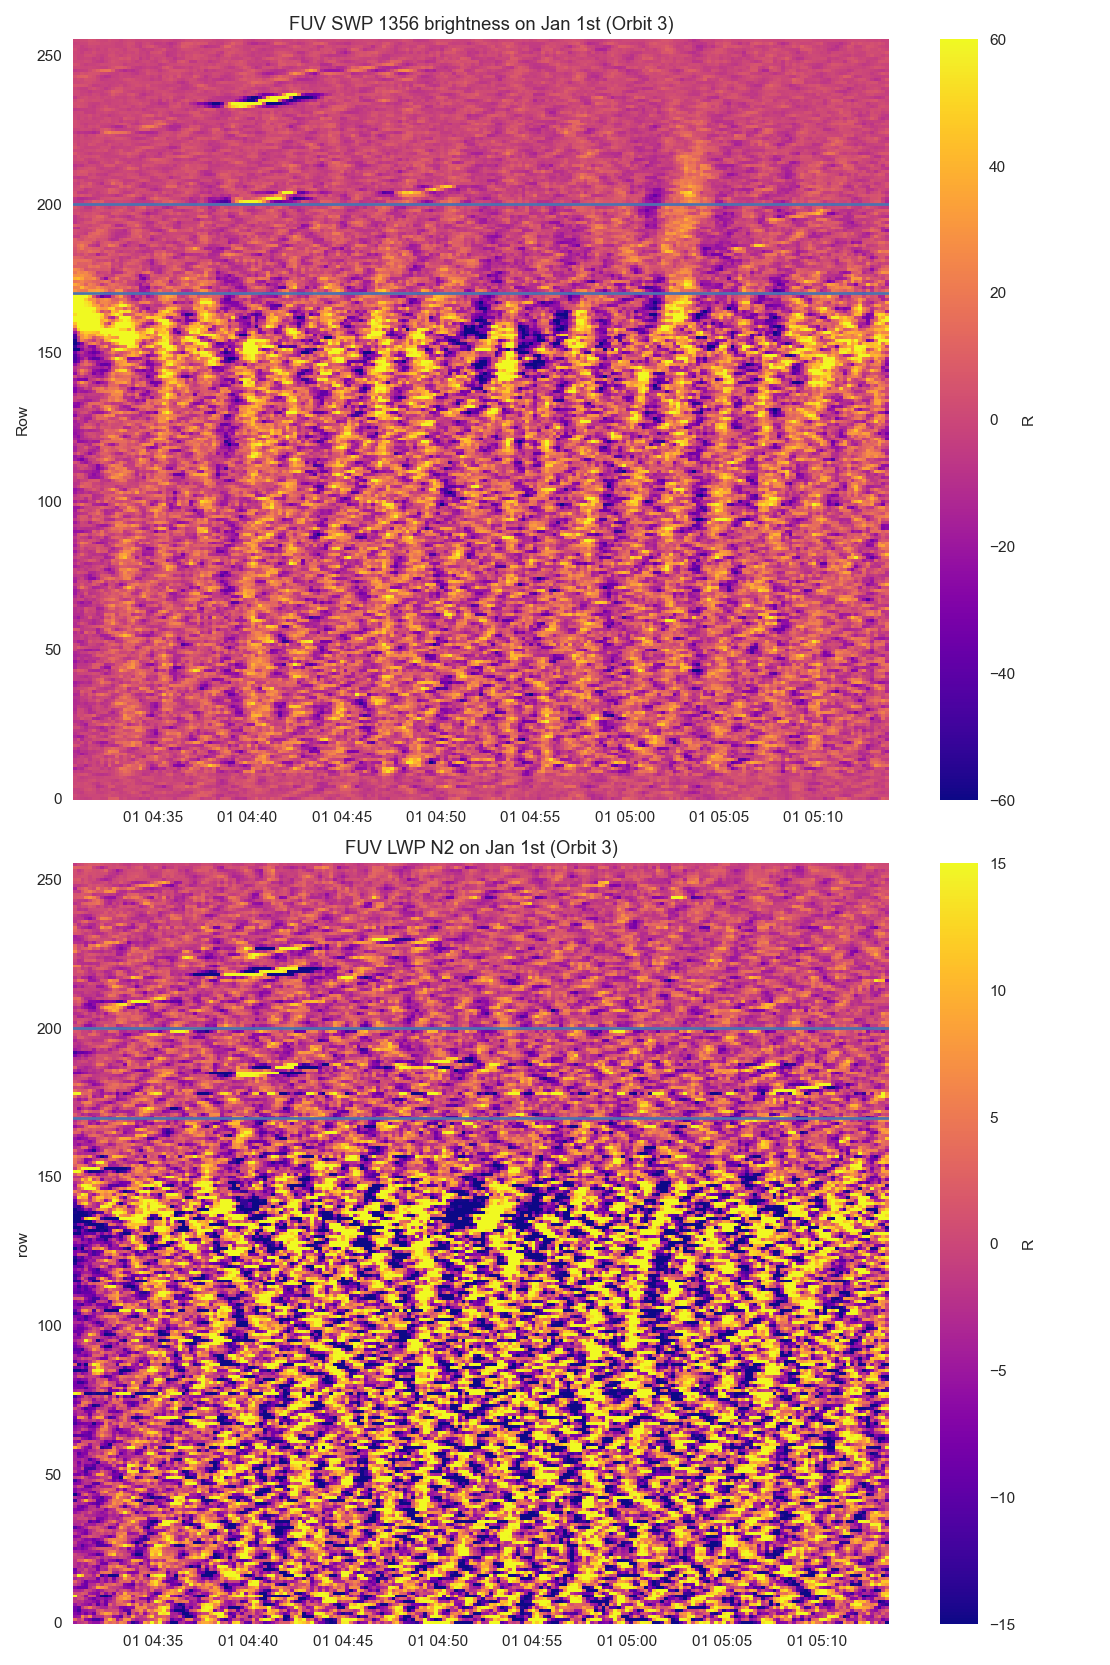

PearsonRResult(statistic=-0.10412365239313806, pvalue=0.13258654530126265)


<IPython.core.display.Javascript object>


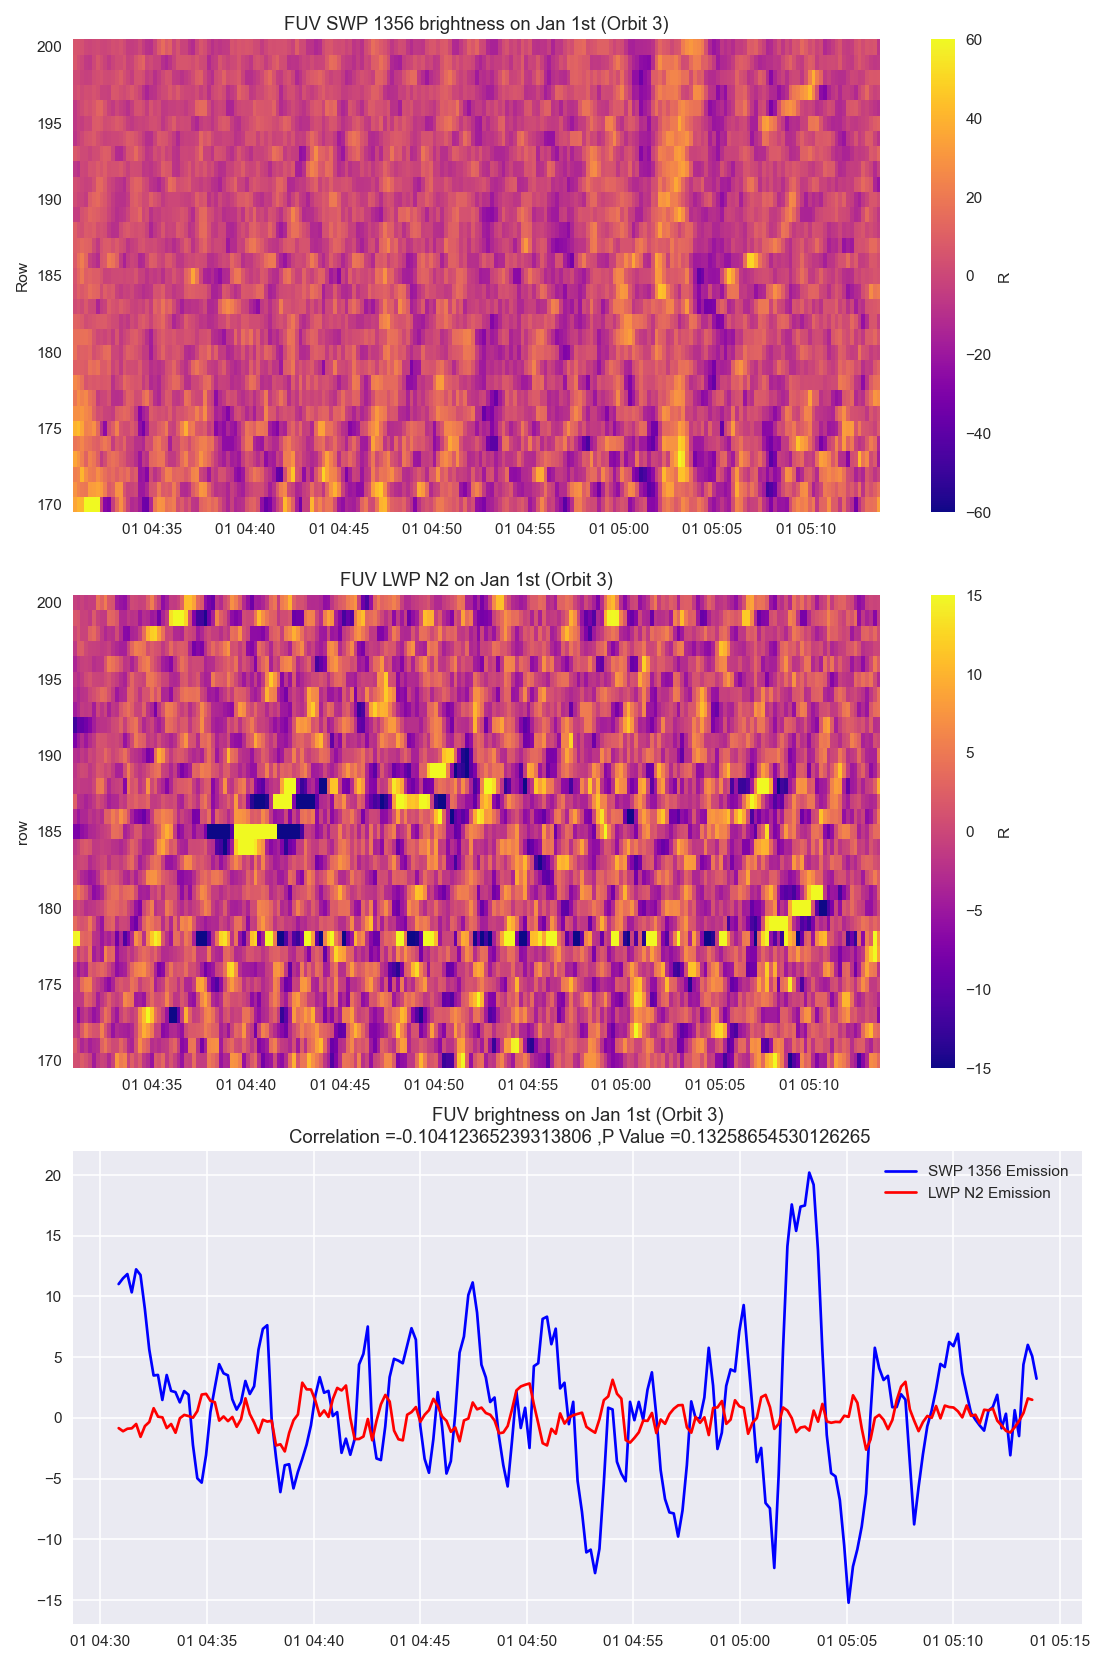

In [51]:
limb_plots("Jan 1st",3)